## Model

The purpose of this blog post is to illustrate how to use set propagation techniques to find initial conditions of an initial-value problem based on a given final state.

The approach taken is to define a *target set* and integrate the dynamical system *backwards in time*, obtaining a set that encloses all admissible trajectories that eventually reach the target set.

To keep the presentation simple, I chose to work with the [projectile motion](https://en.wikipedia.org/wiki/Projectile_motion) of a point particle. See the references at the end of this blog post for some pointers to the relevant literature.

The equations of motion are:

$$
\left\{ \begin{array} 
xx'' &=& 0 \\
y'' &=& -g/m    
\end{array} \right.
$$
where $x(t)$ is the horizontal distance traveled and $y(t)$ is the height of the projectile. We take $m=1kg$ and $g = 9.81m/s^2$.

## Computing forward reachable sets

First assume that the initial conditions are $x_0 = 0$m, $y_0=100$m, $x'_0=10$m/s and $y'_0 = 0$m/s.

In [1]:
using ReachabilityAnalysis, SparseArrays, Plots

A = sparse([1, 2, 4], [3, 4, 5], [1.0, 1.0, -9.81], 5, 5)
X0 = Singleton([0.0, 100.0, 10.0, 0.0, 1.0])
model = @ivp(x' = Ax, x(0) ∈ X0);

In [2]:
sol = solve(model, T=5.0, alg=GLGM06(δ=0.01));

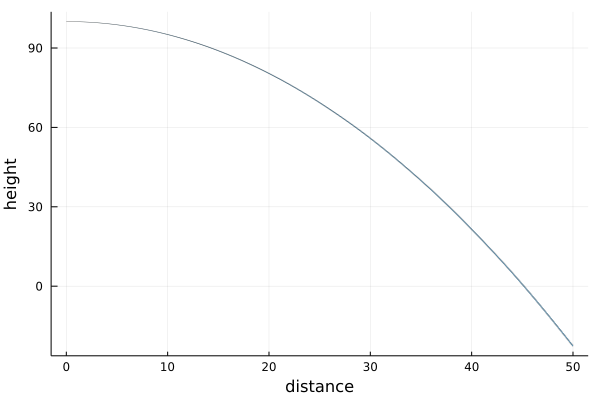

In [3]:
plot(sol, vars=(1, 2), lw=0.4, xlab="distance", ylab="height")

We now consider variation in the vertical position $100 \pm 5$m, and in the horizonal velocity $10\pm 2$m/s, so we define a new set $X_0$ and recompute the flowpipe.

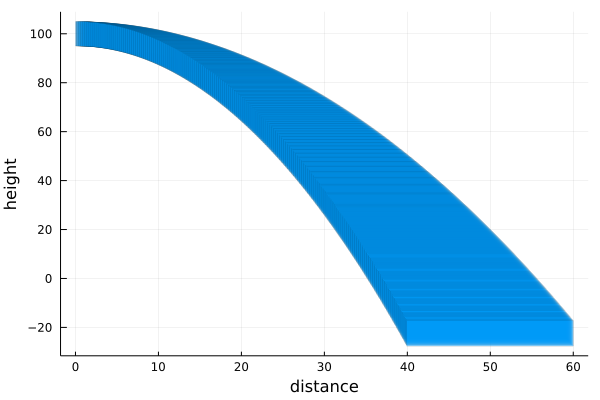

In [4]:
X0 = Hyperrectangle([0.0, 100.0, 10.0, 0.0, 1.0], [0.0, 5.0, 2.0, 0.0, 0.0])
model = @ivp(x' = Ax, x(0) ∈ X0);

sol = solve(model, T=5.0, alg=GLGM06(δ=0.01))

plot(sol, vars=(1, 2), lw=0.2, xlab="distance", ylab="height")

Let's also plot 50 random trajectories:

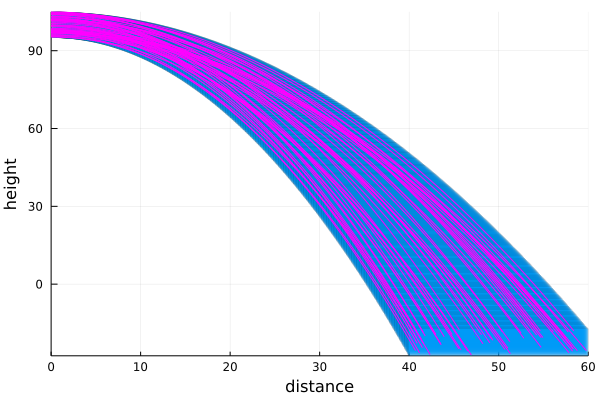

In [5]:
using DifferentialEquations

sol = ReachabilityAnalysis.solve(model, T=5.0, alg=GLGM06(δ=0.01), ensemble=true, trajectories=50)

plot(sol, vars=(1, 2), lw=0.2, xlab="distance", ylab="height")
plot!(ensemble(sol), vars=(1, 2), c=:magenta)

## Adding an invariant

We can specify that the ground level is at $y = 0$ by defining an invariant.

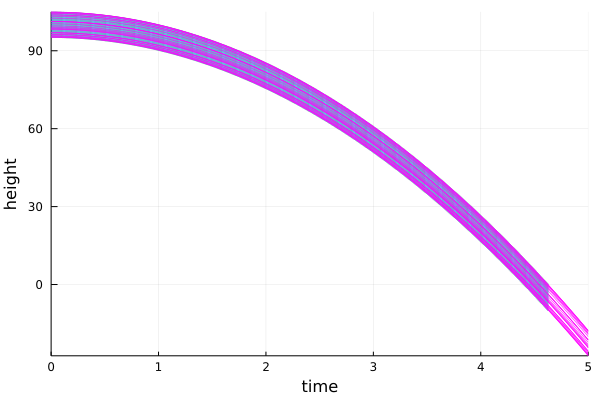

In [6]:
above_ground = HalfSpace([0, -1.0, 0, 0, 0], 0.0) # y ≥ 0

# in the model we specify that x ∈ above_ground at all times
model = @ivp(x' = Ax, x(0) ∈ X0, x ∈ above_ground)

sol = solve(model, T=5.0, alg=GLGM06(δ=0.01), ensemble=true, trajectories=30);

plot(sol, vars=(0, 2), lw=0.2)
plot!(ensemble(sol), vars=(0, 2), c=:magenta, lw=.5, xlab="time", ylab="height")

The simulation stopped before 5 seconds, and it contains the final reach-set that has a non-empty intersection with the invariant.

In [7]:
tspan(sol[end])

[4.61999, 4.63001]

The minimum and maximum values of the final reach-set can be computed as follows:

In [8]:
Yend = project(sol[end], 2) |> set

Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([-4.921383499999126], [5.000490499999998 0.2266110000000015])

In [9]:
low(Yend), high(Yend)

([-10.148484999999127], [0.3057180000008737])

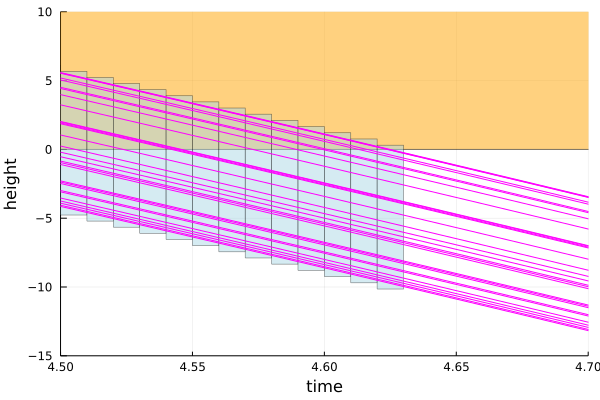

In [10]:
plot(HalfSpace([0, -1.0], 0.0), alpha=.5, c=:orange)
plot!(sol[end-23:end], vars=(0, 2), lw=0.6, c=:lightblue)

plot!(ensemble(sol), vars=(0, 2), c=:magenta, xlims=(4.5, 4.7), ylims=(-15, 10), xlab="time", ylab="height")

## Computation backwards in time

Suppose that we want to compute the set of states that eventually reach height zero at $x$ distance $(50 \pm 2)$m.

A priori we ignore the target $y$ velocity, but we can pick rough estimates and as a post-processing step intersect the forward reachable states with the initial estimate.

Under the transformation $s = -t$, then the state transition matrix is $\Phi = e^{-A\delta}$.

In [11]:
using ReachabilityAnalysis, SparseArrays, Plots

Xfinal = Hyperrectangle([50.0, 0.0, 10.0, -40.0, 1.0], [2.0, 0.0, 2.0, 1.0, 0.0])

modelback = @ivp(x' = -A*x, x(0) ∈ Xfinal);

In [12]:
solback = ReachabilityAnalysis.solve(modelback, T=5.0, alg=GLGM06(δ=0.01), ensemble=true, trajectories=50);

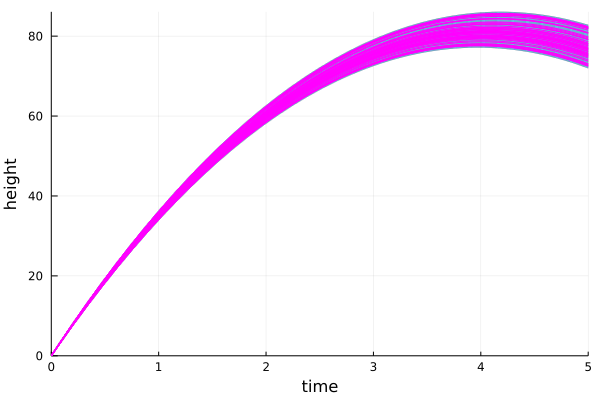

In [13]:
plot(solback, vars=(0, 2), lw=0.2)
plot!(ensemble(solback), vars=(0, 2), c=:magenta, xlab="time", ylab="height")

This plot should be read "backwards in time": the set of states at $t = 5$s in the plot are those that, under the forward dynamics, will arrive at height $0$ in $5$seconds.

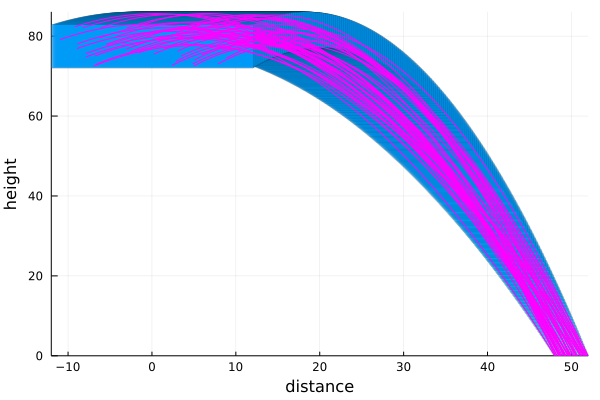

In [14]:
plot(solback, vars=(1, 2), lw=0.2)
plot!(ensemble(solback), vars=(1, 2), c=:magenta, xlab="distance", ylab="height")

Clearly, should we have chosen more random trajectories the coverage would be better.

Nowe we will propagate the final set forward in time, just to verify the hypothesis.

In [15]:
Xinitial = set(solback[end])

Zonotope{Float64, Vector{Float64}, Matrix{Float64}}([0.039999999999555905, 77.42525000000055, 10.0, 9.000950000000005, 1.0], [2.0599999999999987 0.0 -9.979999999999876 0.0; 0.0 0.20500000000000004 0.0 -5.234759500000034; … ; 0.0 0.0 0.0 1.0490500000000011; 0.0 0.0 0.0 0.0])

We choose the support-function based algorithm `LGG09` because it lets us represent exactly `Xinitial` in the conservative time discretization.

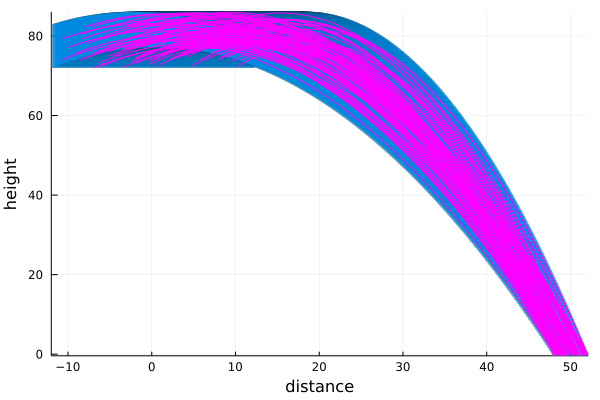

In [16]:
model = @ivp(x' = A*x, x(0) ∈ Xinitial)

solforward = ReachabilityAnalysis.solve(model, T=5.0, alg=LGG09(δ=0.01, n=5, vars=(1, 2)), ensemble=true, trajectories=100);

plot(solforward, vars=(1, 2), lw=0.2)
plot!(ensemble(solforward), vars=(1, 2), c=:magenta, xlab="distance", ylab="height")

## Conclusion

Using set propagation we can can solve the backwards reachable set (BRS) problem, obtaining a set that encloses all possible trajectories that reach a given target set.

In this blog I considered an extremely simple setting, but interestingly, it is also possible to backwards propagate nonlinear dynamical systems, to estimate regions of stability, and to synthesize parameters using BRS... but those would be topics for another post ;)

To conclude, here are a few references that address the BRS problem and related applications:

- Rwth, Xin Chen, Sriram Sankaranarayanan, and Erika Ábrahám. "Under-approximate flowpipes for non-linear continuous systems." 2014 Formal Methods in Computer-Aided Design (FMCAD). IEEE, 2014.

- Han, Weiqiao, and Russ Tedrake. "Semidefinite Outer Approximation of the Backward Reachable Set of Discrete-time Autonomous Polynomial Systems." arXiv preprint arXiv:1803.07725 (2018).

- Xue, Bai, Zhikun She, and Arvind Easwaran. "Underapproximating backward reachable sets by semialgebraic sets." IEEE Transactions on Automatic Control 62.10 (2017): 5185-5197.

- Rocca A, Forets M, Magron V, Fanchon E, Dang T. Occupation measure methods for modelling and analysis of biological hybrid systems. IFAC-PapersOnLine. 2018 Jan 1;51(16):181-6.

- Mitchell, Ian M. "Comparing forward and backward reachability as tools for safety analysis." International Workshop on Hybrid Systems: Computation and Control. Springer, Berlin, Heidelberg, 2007. [presentation](https://www.cs.ubc.ca/~mitchell/Class/CS513.2008W1/Handouts/reachCompare.pdf)

- Xue, Bai, Zhikun She, and Arvind Easwaran. "Under-approximating backward reachable sets by polytopes." International Conference on Computer Aided Verification. Springer, Cham, 2016. [article](https://link.springer.com/chapter/10.1007/978-3-319-41528-4_25)

- Backwards Reachability: A Tutorial. Using reachability analysis to compute safety guarantees for safety critical dynamic systems. Ali Kuwajerwala, Cathlyn Chen. Robot Vision and Learning Lab at the University of Toronto. [notes](https://rvl.cs.toronto.edu/backwards-reachability/)